In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from src.data_processor.phase_2.prob2.v2 import  Phase2Prob2FeatureProcessor
import numpy as np

In [3]:
df = pd.read_parquet("D:/Data/MLOPS_2023/data_phase-2/phase-2/prob-2/raw_train.parquet")
df['label'].value_counts()

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Data/MLOPS_2023/data_phase-2/phase-2/prob-2/raw_train.parquet'

In [5]:
df.reset_index(drop=True, inplace=True)
x = df.groupby(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
                'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
                'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
                'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
                'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
                'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
                'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
                'feature37', 'feature38', 'feature39', 'feature40', 'feature41']).apply(lambda x : pd.Series({'list_index':list(x.index),'list_label':list(x['label'])})).reset_index()
a = x[x['list_label'].apply(lambda x: len(x)>1)]
blacklist = []
for t in a['list_index'].values:
    blacklist.extend(t)
    index = np.array(blacklist)
not_index = np.setdiff1d(df.index.to_numpy(), index)
df = df.iloc[not_index]
df.reset_index(inplace=True, drop=True)
# df['label'].value_counts()

In [6]:
df['label'].value_counts()

Normal                   21064
Exploits                  6593
Denial of Service         5609
Information Gathering     2216
Other                     1842
Malware                    489
Name: label, dtype: int64

In [7]:
HyperParameters={'objective': 'multiclass',
                 'n_estimators':100,
                 'learning_rate':0.1,
                 'max_depth':11,
                 'colsample_bytree':0.5,
                 'subsample':0.8,
                 'reg_alpha':1.2,
                 'reg_lambda':10,
                 'random_state':42}
            
hyper_parameters = HyperParameters.copy()

In [8]:
processor = Phase2Prob2FeatureProcessor()
new_df = processor.transform(df)

In [9]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
TARGET = 'label'

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
# study = optuna.create_study()  # Create a new study.
# study.optimize(run, n_trials=100)

In [12]:
hyper_parameters

{'objective': 'multiclass',
 'n_estimators': 100,
 'learning_rate': 0.1,
 'max_depth': 11,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'reg_alpha': 1.2,
 'reg_lambda': 10,
 'random_state': 42}

In [13]:
TARGET = 'label'
# hyper_parameters['objective'] = 'multiclass'
models = []
scores = []
oofs = np.empty(df.shape[0], dtype='object')
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df[TARGET])):
    # Xy_train = new_df.iloc[train_idx]
    # Xy_train['label'] = df.iloc[train_idx][TARGET]
    # Xy_train_NORMAL = Xy_train[Xy_train.label.apply(lambda x: x == 'Malware')]
    # Xy_train_NORMAL_sample = Xy_train_NORMAL.sample(frac=1, random_state=42)
    # # print(Xy_train_NORMAL_sample['label'].value_counts())
    # Xy_train_OTHER = Xy_train[Xy_train.label.apply(lambda x: x != 'Malware')]
    # Xy_train_sample = pd.concat([Xy_train_OTHER,Xy_train_NORMAL_sample])
    # Xy_train_sample = Xy_train_sample.sample(frac=1,random_state=123)
    # print(Xy_train_sample['label'].value_counts())

    X_train = new_df.iloc[train_idx]
    y_train = df.iloc[train_idx][TARGET]
    X_valid = new_df.iloc[valid_idx]
    y_valid = df.iloc[valid_idx][TARGET]


    print(X_train.shape, X_valid.shape)
    print(y_train.shape, y_valid.shape)
    model = LGBMClassifier(**hyper_parameters)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
    # model.fit(X_train, y_train,
    #           cat_features=categorical,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
    models.append(model)
    y_pred = model.predict(X_valid)
    oofs[valid_idx] = y_pred

    print(f"fold {i} : {accuracy_score(y_valid, y_pred)}")
    print(classification_report(y_valid, y_pred))
    scores.append(accuracy_score(y_valid, y_pred))

print(np.mean(scores), np.std(scores))
print(classification_report(df[TARGET], oofs))
print(accuracy_score(df[TARGET], oofs))

(30250, 10) (7563, 10)
(30250,) (7563,)
[50]	training's multi_logloss: 0.383361	valid_1's multi_logloss: 0.414723
[100]	training's multi_logloss: 0.340408	valid_1's multi_logloss: 0.403641
fold 0 : 0.8281105381462383
                       precision    recall  f1-score   support

    Denial of Service       0.60      0.48      0.53      1122
             Exploits       0.79      0.87      0.83      1319
Information Gathering       0.85      0.81      0.83       443
              Malware       0.52      0.22      0.31        98
               Normal       0.88      0.92      0.90      4213
                Other       0.99      0.85      0.92       368

             accuracy                           0.83      7563
            macro avg       0.77      0.69      0.72      7563
         weighted avg       0.82      0.83      0.82      7563

(30250, 10) (7563, 10)
(30250,) (7563,)
[50]	training's multi_logloss: 0.379415	valid_1's multi_logloss: 0.431919
[100]	training's multi_logloss: 0.33

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df[TARGET],oofs,labels=models[0].classes_), display_labels=models[0].classes_)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
disp.plot(ax=ax)

In [15]:
confusion_matrix(df[TARGET],oofs,labels=models[0].classes_)

array([[ 2762,   757,    60,    55,  1965,    10],
       [  330,  5646,   142,    30,   441,     4],
       [   45,   241,  1773,     4,   153,     0],
       [  150,    94,    18,   113,   107,     7],
       [ 1287,   288,    75,    27, 19384,     3],
       [   50,   165,     3,     6,    37,  1581]], dtype=int64)

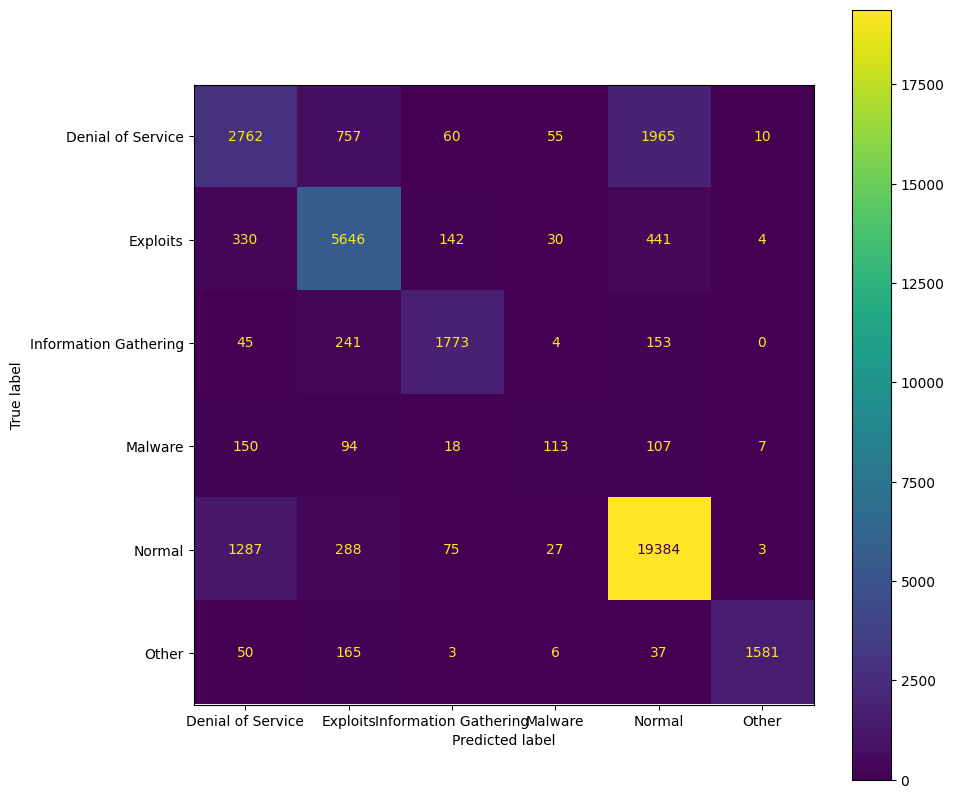

In [17]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df[TARGET],
           eval_set=[(new_df[FEATURES],df[TARGET])],
           eval_metric=["logloss"],
           categorical_feature=categorical,
           verbose=50)

with open(f'../checkpoints/phase-2/prob-2/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

[50]	valid_0's multi_logloss: 0.383376
[100]	valid_0's multi_logloss: 0.343543


In [18]:
gmodel.feature_name_

['feature26',
 'feature7',
 'feature25',
 'feature8',
 'feature11',
 'feature27',
 'feature24',
 'feature1',
 'feature17',
 'feature12']

In [17]:
len(processor.FEATURES)

21

In [18]:
feats = pd.DataFrame({'feature':gmodel.feature_name_, 'score':gmodel.feature_importances_}).sort_values('score',ascending=False)

In [19]:
feats.feature.values

array(['feature26', 'feature7', 'feature25', 'feature8', 'feature11',
       'feature27', 'feature24', 'feature1', 'feature17', 'feature12',
       'feature18', 'feature16', 'feature40', 'feature5', 'feature29',
       'feature9', 'feature38', 'feature31', 'feature28', 'feature36',
       'feature41'], dtype=object)